In [1]:
import networkx as nx
import os, re
from collections import Counter
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *
import numpy as np
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

In [2]:
afi_files = [f for f in os.listdir(os.getcwd()) if f[:2]=="af" and f.endswith(".txt")] #find all the AFI text files

In [3]:
#compile all regex to have them handy
afi_expand_pattern = re.compile(r'AIR FORCE INSTRUCTION ?[0-9]+-? ?[0-9]+', flags=re.IGNORECASE) #find AFI title
afi_date_ref = re.compile(r'\d{1,2} ?(?:January|Februar|March|April|May|June|July|August|September|October|November|December) ?\d{4}',flags=re.IGNORECASE)
afi_ref = re.compile(r'afi-? ?[0-9]+-? ?[0-9]+', flags=re.IGNORECASE) #find AFI acronyms

In [4]:
for f in afi_files:
    afi_file = open(f,encoding='latin').read()
    print(f, "-",len(afi_file))
    print(afi_date_ref.search(afi_file).group(0))
    afi_count = Counter(afi_ref.findall(afi_file))
    for k in sorted(afi_count):
        print(k.replace(" ","") ,":",afi_count[k])
    for m in afi_ref.finditer(afi_file):
        print("CONTEXT:",afi_file[(m.start()-120):(m.end()+30)].replace("\r"," ").replace("\n"," "))

afi61-101.txt - 46005
14 MARCH 2013
AFI10-601 : 2
AFI14-111 : 2
AFI61 : 1
AFI63-101 : 1
AFI61-101 : 1
CONTEXT: ng.   RELEASABILITY:   There are no releasability restrictions on this publication        OPR: SAF/AQR      Supersedes: AFI61-101, 9 May 2005   Certified by: S
CONTEXT: aling with Applied Technology Councils  (ATC) and Advanced Technology Demonstrations (ATD). This is a major revision to AFI 61- 101 and must be reviewed in 
CONTEXT: pability needs identified through Capabilities-Based  Assessments (CBA) or other capability planning analyses (refer to AFI 10-601, Operational  Capability Requ
CONTEXT: unities will  identify technology needs, technical risk areas, intelligence sensitivity and supportability  issues (per AFI 14-111), and reliability, availabili
CONTEXT: FPD 61-1, Management of Science and Technology, 18 August 2011   AFPD 90-11, Strategic Planning System, 26 March 2009   AFI 63-101, Acquisition and Sustainment 
CONTEXT: trategic Planning System, 26 March 2009   AF

In [5]:
G = nx.DiGraph()
for f in afi_files:
    afi_title = os.path.splitext(f)[0].upper()
    afi_file = open(f, encoding='latin').read()
    date = afi_date_ref.search(afi_file).group(0)
    #now add the node and append attributes (filename title, date, length, afi number as float
    G.add_node(afi_title,{'date':date,'length':len(afi_file),'afinum':re.search('\d+\.?\d+', afi_title.replace("-",".")).group()})
    afi_ref_count = Counter(afi_ref.findall(afi_file))
    for match in afi_ref_count:
        G.add_node(match.upper().replace(" ",""))

In [6]:
for f in afi_files:
    afi_title = os.path.splitext(f)[0].upper() #name the node using the textfile name
    afi_file = open(f, encoding='latin').read() #read the contents
    afi_ref_count = Counter(afi_ref.findall(afi_file)) #match the contents
    for match in afi_ref_count: #add an edge from the opened afi to each node referenced, using frequency as weight
        G.add_edge(afi_title,match.upper().replace(" ",""),{'weight':afi_ref_count[match]})

In [14]:
print("G nodes:",G.number_of_nodes())
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
tokeep = [n for n in G if G.out_degree(n) > 2 or G.in_degree(n) > 2]
H = nx.DiGraph(G.subgraph(tokeep)) #create DiGraph of nodes with more than 2 connections
nodesize=nx.get_node_attributes(G,'length')
maxnodesize = max(nodesize.values()) #normalize node size by max value
print(sorted(G.nodes()))
print(G.nodes(data=True))

G nodes: 111
['AFI10-1211', 'AFI10-245', 'AFI10-2801', 'AFI10-601', 'AFI10-701', 'AFI10-703', 'AFI11-215', 'AFI11-401', 'AFI13-204', 'AFI14-111', 'AFI14-205', 'AFI16-1001', 'AFI16-1005', 'AFI16-110', 'AFI16-1404', 'AFI16-1406', 'AFI16-1604', 'AFI16-402', 'AFI16-601', 'AFI16-608', 'AFI16-701', 'AFI16402', 'AFI17-100', 'AFI17-101', 'AFI17-110', 'AFI17-120', 'AFI17-130', 'AFI17-140', 'AFI17-220', 'AFI20-106', 'AFI20-110', 'AFI20-118', 'AFI21-101', 'AFI21-102', 'AFI21-103', 'AFI21-107', 'AFI21-113', 'AFI21-201', 'AFI21-204', 'AFI23-101', 'AFI23-111', 'AFI24-203', 'AFI25-201', 'AFI31-101', 'AFI32-7020', 'AFI32-9004', 'AFI32-9005', 'AFI33-112', 'AFI33-332', 'AFI33-360', 'AFI33-364', 'AFI33-393', 'AFI35-102', 'AFI36-1301', 'AFI36-2107', 'AFI36-2110', 'AFI36-2251', 'AFI36-2406', 'AFI36-2640', 'AFI38-401', 'AFI41-201', 'AFI51-1101', 'AFI51-303', 'AFI51-402', 'AFI60-101', 'AFI60-106', 'AFI61', 'AFI61-101', 'AFI61-102', 'AFI61-201', 'AFI61-202', 'AFI61-203', 'AFI61-204', 'AFI61-205', 'AFI61-301',

<IPython.core.display.Javascript object>


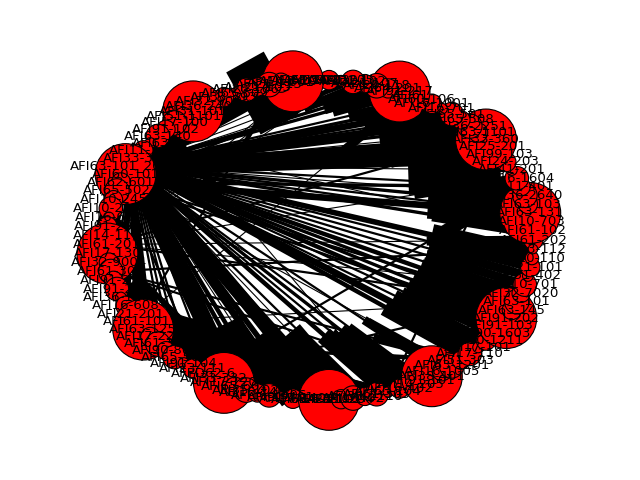

In [16]:
#nx.draw_shell(G, with_labels=True, width=weights)
nx.draw_shell(G, node_size=[v*3000/maxnodesize for v in nodesize.values()], with_labels=True, width=weights, arrows=True)